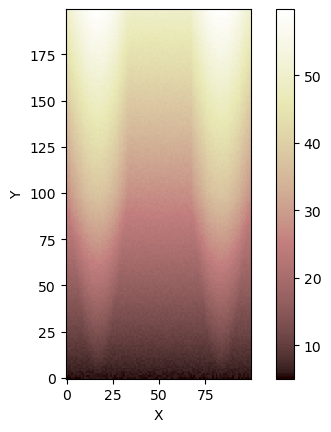

In [70]:
from landlab.components import (
    FlowDirectorD8,
    FlowDirectorMFD,
    FlowDirectorSteepest,
    FlowAccumulator, 
    SinkFillerBarnes,
    DepressionFinderAndRouter
)

from bmi_topography import Topography
from landlab import RasterModelGrid
from landlab.plot.drainage_plot import drainage_plot
from landlab.plot.graph import plot_graph
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

#define the grid
size_x = 100
size_y = 200
spacing = 1.0
grid = RasterModelGrid((size_y, size_x), xy_spacing=spacing)

# morph the grid with a sine function
ice_height = 10
bedrock_slope = 0.22
soil_thickness = 5
moraine_disappears_at_y = 100

# add the topography    
z_ice = grid.add_zeros('ice_thickness', at='node')
z_soil = grid.add_zeros('soil_thickness', at='node')
z_bed = grid.add_zeros('bedrock_thickness', at='node')
elev = grid.add_zeros('topographic__elevation', at='node')

x = grid.x_of_node
y = grid.y_of_node

# setting ice elevation respected to the base elevation
z = ice_height * np.sin(np.pi*x / (size_x/3)) 
# get z where y is less than moraine_disappears_at_y
z[y<moraine_disappears_at_y] += (y[y<moraine_disappears_at_y] - moraine_disappears_at_y) * ice_height/moraine_disappears_at_y
z[z<0] = 0 # cut the sine function at 0

z_ice += z 
z_soil += soil_thickness
z_bed += bedrock_slope * y
elev = z_ice + z_soil + z_bed + np.random.uniform(0.0, 1.1, size=z.shape)

grid.imshow(elev)

In [71]:
from landlab.components import VegCA

In [72]:
# Add required fields for VegCA (minimal initialization)
pft = grid.add_zeros('vegetation__plant_functional_type', at='cell', dtype=int)
cwt = grid.add_zeros('vegetation__cumulative_water_stress', at='cell')
tvc = grid.add_zeros('vegetation__target_veg_cov', at='cell')
cvc = grid.add_zeros('vegetation__current_veg_cov', at='cell')

# Now VegCA can be safely instantiated
vegca = VegCA(grid=grid)

In [73]:
# Assign plant functional type (PFT) to cells in the first 5 rows
cells = grid.core_cells[grid.node_y[grid.core_cells] < 5]
pft[cells] = 1


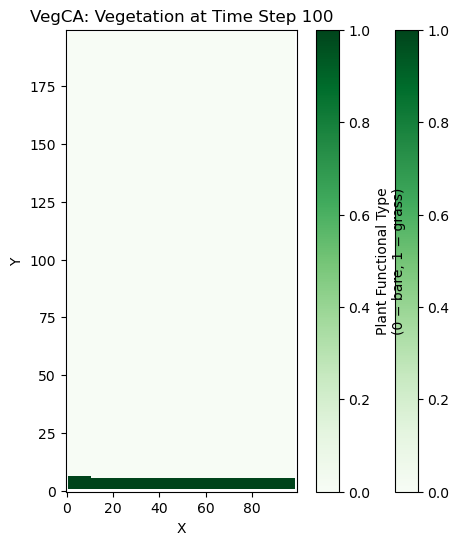

In [74]:
plt.figure(figsize=(6, 6))
grid.imshow('cell', 'vegetation__plant_functional_type', cmap='Greens')
plt.title(f"VegCA: Vegetation at Time Step {t}")
plt.colorbar(label='Plant Functional Type\n(0 = bare, 1 = grass)')

In [52]:
nrows, ncols = grid.number_of_node_rows, grid.number_of_node_columns
ncols

100

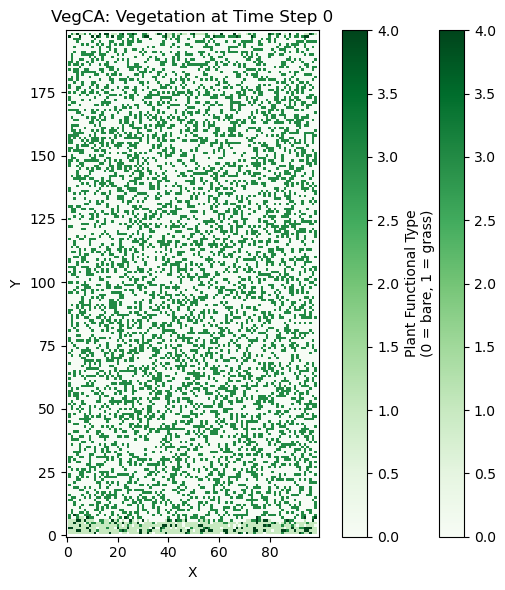

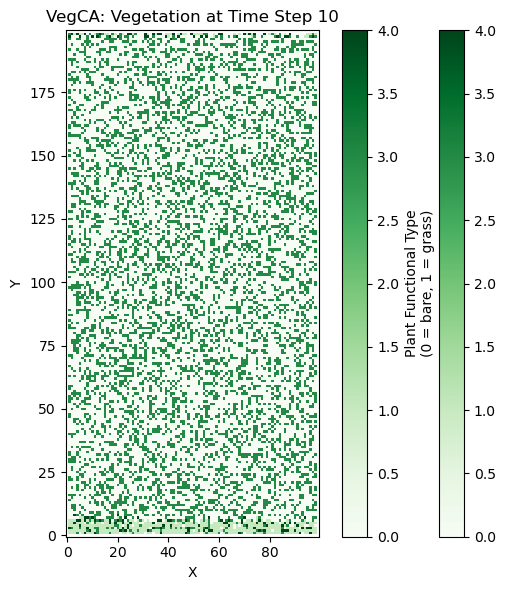

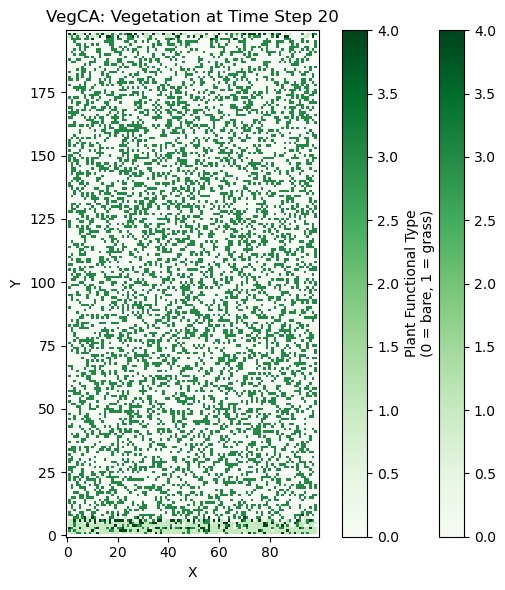

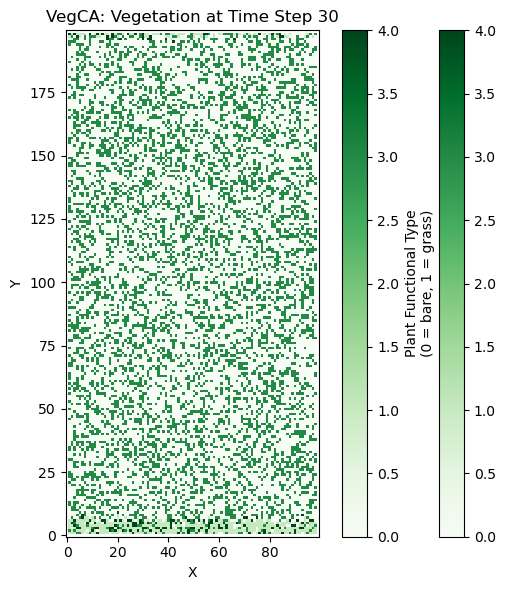

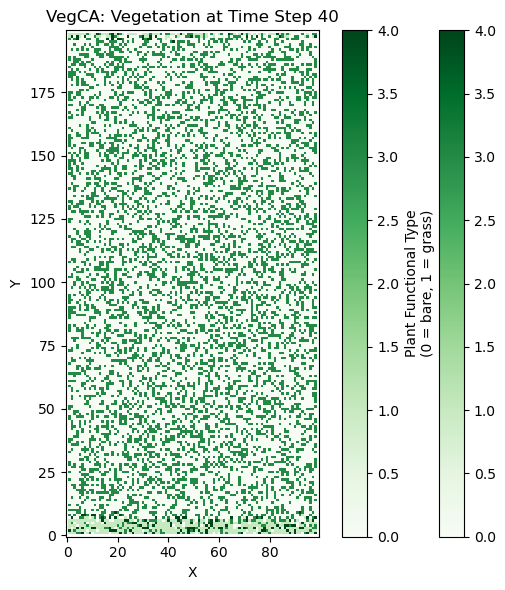

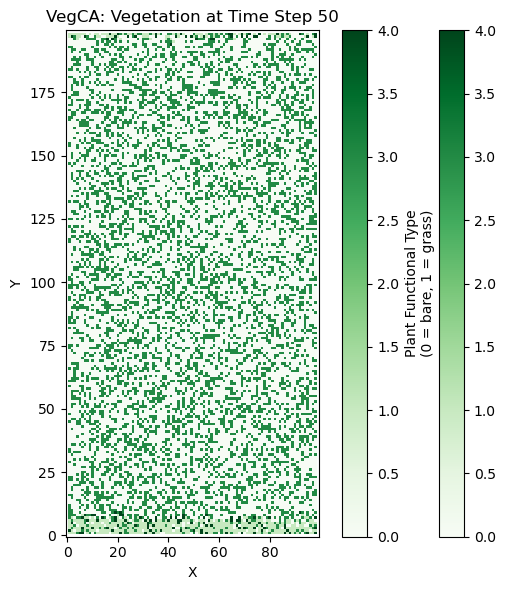

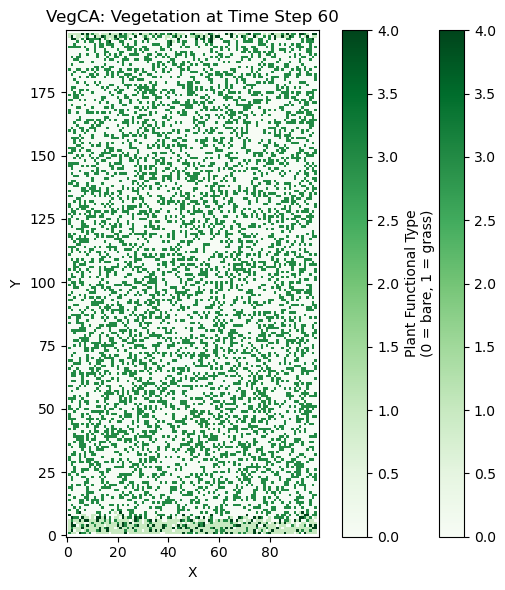

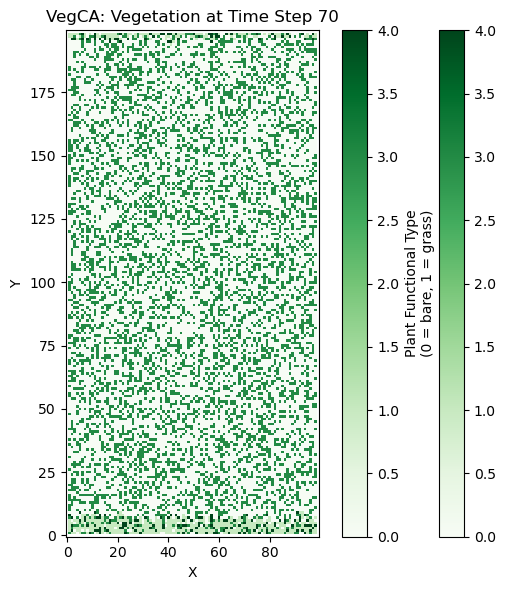

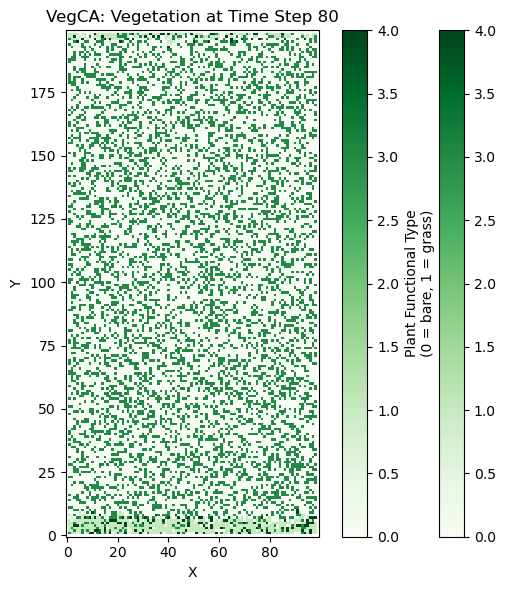

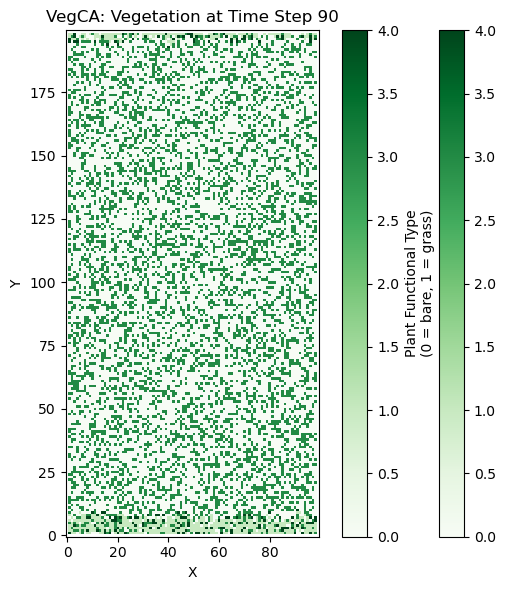

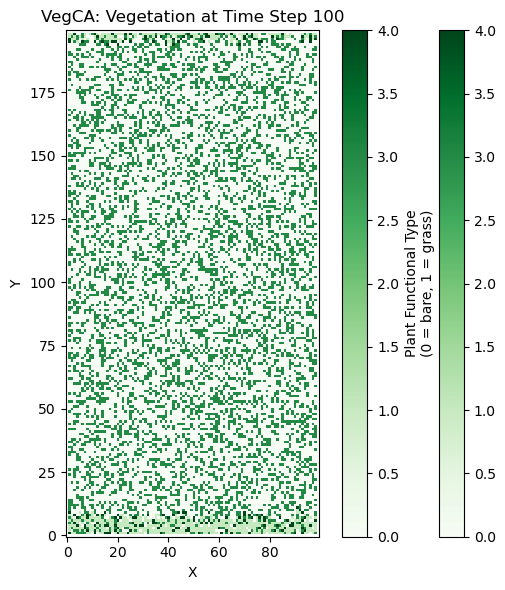

In [54]:
nrows, ncols = grid.number_of_node_rows, grid.number_of_node_columns
n_steps = 100
for t in range(0, n_steps + 1, 10):
    for _ in range(10):
        vegca.update()

    # Plot the vegetation state at each checkpoint
    plt.figure(figsize=(6, 6))
    grid.imshow('cell', 'vegetation__plant_functional_type', cmap='Greens')
    plt.title(f"VegCA: Vegetation at Time Step {t}")
    plt.colorbar(label='Plant Functional Type\n(0 = bare, 1 = grass)')

    # Estimate vegetation front (furthest upslope row with grass)
    # pft_grid = pft.reshape((nrows - 2, ncols - 2))
    # rows_with_veg = np.where(np.any(pft > 0, axis=1))[0]
    # if len(rows_with_veg) > 0:
    #     front_row = rows_with_veg[-1]
    #     plt.axhline(front_row, color='red', linestyle='--')
    #     plt.text(1, front_row + 1, f"Front ~ row {front_row}", color='red')

    plt.tight_layout()
    plt.show()

In [29]:
def plot_3D(size_x, size_y, topo, spacing, title="Topography"):
    """Plot the 3D surface of the topography."""
    X, Y = np.meshgrid(np.arange(0,size_x,spacing),np.arange(0,size_y,spacing))
    Z = topo.reshape(size_y, size_x)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.set_box_aspect((1, size_y/size_x, Z.max()/size_x))
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.show()


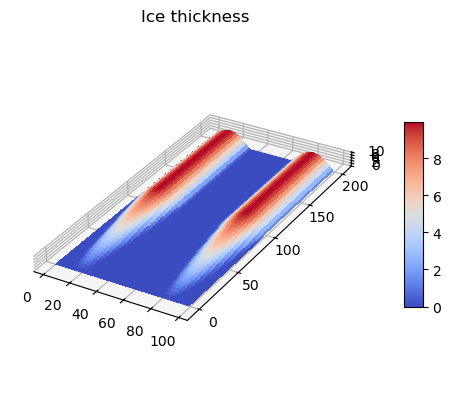

In [30]:
plot_3D(size_x, size_y, z_ice, spacing, title='Ice thickness')

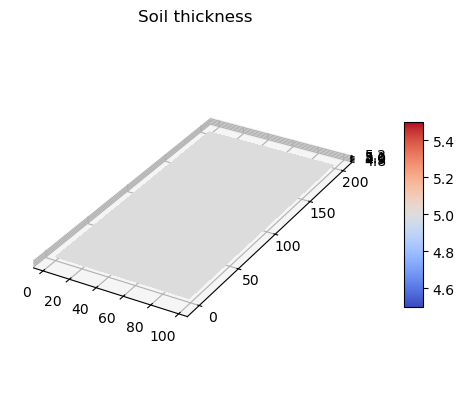

In [31]:
plot_3D(size_x, size_y, z_soil, spacing, title='Soil thickness')

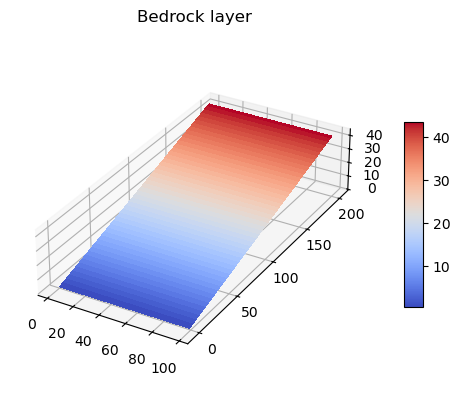

In [32]:
plot_3D(size_x, size_y, z_bed, spacing, title='Bedrock layer')

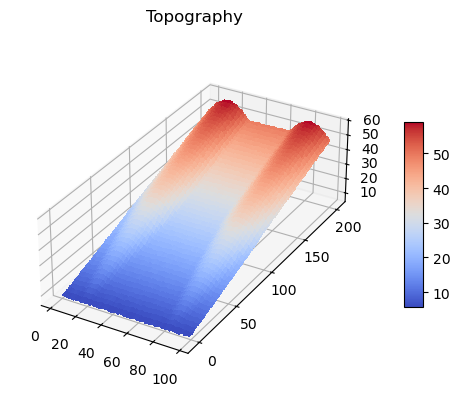

In [33]:
plot_3D(size_x, size_y, elev, spacing)

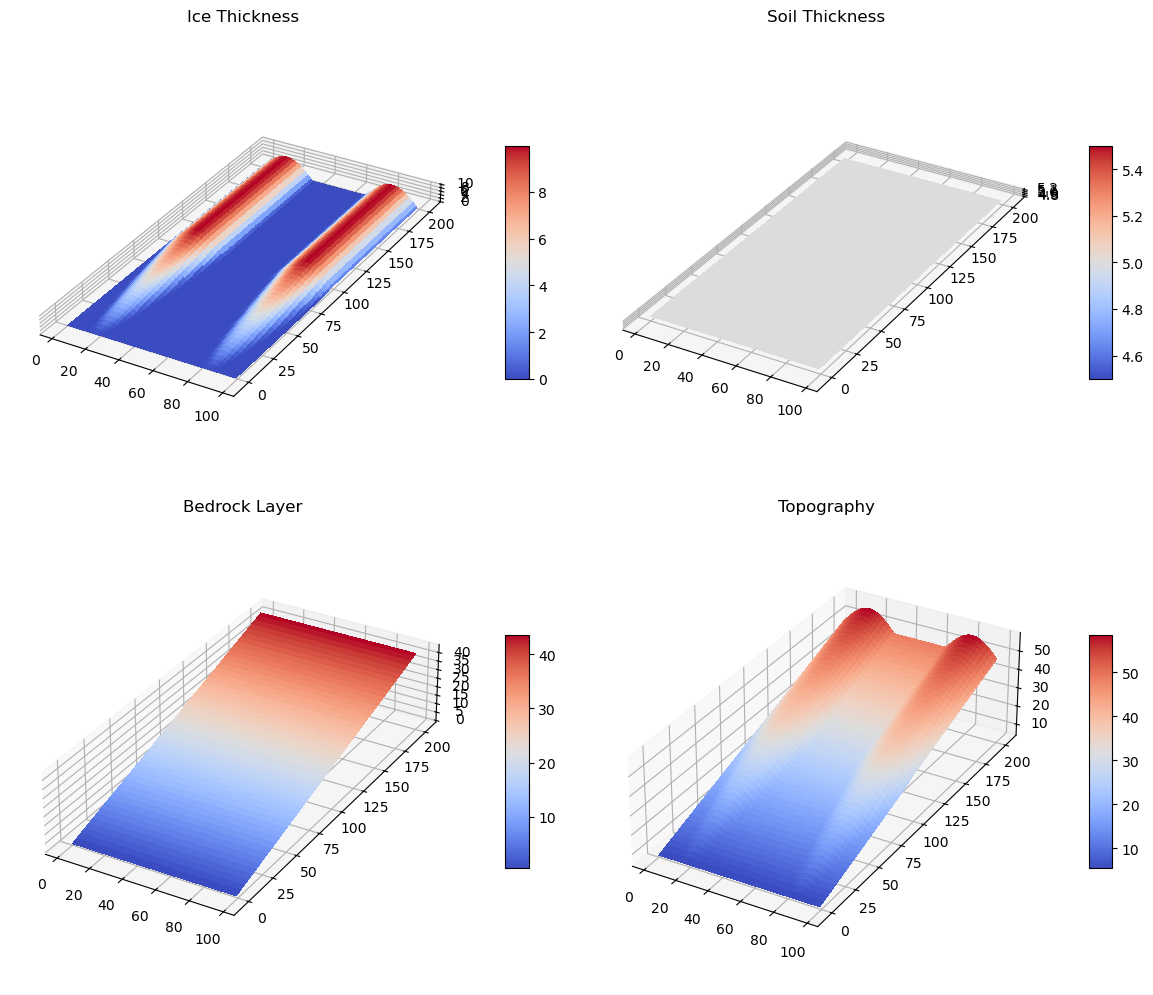

In [7]:
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 10))

def plot_each_axs(axs,size_x,size_y,topo, title="Topography"):
    X, Y = np.meshgrid(np.arange(0,size_x,spacing),np.arange(0,size_y,spacing))
    Z = topo.reshape(size_y, size_x)
    axs.set_box_aspect((1, size_y/size_x, Z.max()/size_x))
    axs.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs.set_title(title)
    cbar = fig.colorbar(axs.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False), ax=axs, shrink=0.5, aspect=10)

# Plot Ice Thickness
plot_each_axs(axs[0, 0], size_x, size_y, z_ice, title="Ice Thickness")

# Plot Soil Thickness
plot_each_axs(axs[0, 1], size_x, size_y, z_soil, title="Soil Thickness")

# Plot Bedrock Layer
plot_each_axs(axs[1, 0], size_x, size_y, z_bed, title="Bedrock Layer")

# Plot Topography
plot_each_axs(axs[1, 1], size_x, size_y, elev, title="Topography")

# Adjust layout
plt.tight_layout()
plt.show()